Let's take a look at what we'll cover:
1. Object Detection: Task Definition
2. Object Detection: Challenges
3. Detecting Multiple Objects: Sliding Window
4. R-CNN: Region Based CNN
5. R-CNN: Test Time, Intersection Over Union (IoU)
6. Overlapping Boxes: Non-Max Supression (NMS)
7. Evaulating Object Detectors
8. Faster R-CNN: Learnable Region Proposals

# <font color="red">1. Object Detection: Task Definiton</font>

**Object detection** is a computer vision task that allows us to identify and locate objects in an image or a video.
The model predicts where each object is and what label should be applied.
With this kind of identification and localization, object detection can be used to count objects in a scene and determine and track their precise locations, all while accurately labeling them.
![image](https://www.fritz.ai/images/cats_and_person.jpg)
<font color="red">An image that contains two cats and a person.</font> Object detection allows us to at once classify the types of things found while also locating instances of them within the image.

**Classification** -- what's in image. overall label for an image

**Semantic Segmentation** -- no objects, just pixels

**Object Detection** -- muultiple object detection and localization

**Input** - single RGB image 

**Output** - is going to be a set of detected objects. For each object we're going to output several things.

  * <font color="green">*category label*</font> - which category.  Ahead of time we're going to pre-specify (CIFAR10, ImageNet)

  * <font color="green">*bounding box*</font> - spatial extent of the object. The location of each object (x,y,w,h).
    * <font color="blue">x and y is the center of the box in pixels.
    * w and h is width and height of the box.</font>

# <font color="red">2. Object Detection: Challenges</font>

1. **Multiple Outputs:** Need to output variable numbers of objects per image.

2. **Multiple Types of Output:** Need to predict "what" (category label) and "where" (bounding box).

3. **Large Images:** Classification works at 224x224, for object detection task we need higher resolution, often 800x600.

## <font color="blue">Detecting a Single Object</font>

![image](https://machinethink.net/images/object-detection/localization-network@2x.jpg)
We can use a simple architecture to detect a single object. We have an input image. Then we fed it into a simple CNN arc, like VGG or ResNet. At the end we have a vector representation of image. So, we can have a branch do the classification. What is in the image? It will output scores for each class. It's going to be trained with softmax loss on the ground truth category.

So far it's the same with image classification process. But now we have a new branch that outputs the bounding box's coordinations. x, y, w, h. It's input is the same vector representation of the image, now it has a fully connected layer 4096 to 4 since we need 4 outputs. And they're going to be trained with some regression loss, like L2 loss. L2 difference between the predicted box coordinates with the real box coordinates.

The problem is now we have two loss. Since we need only one loss to compute gradient descent, we need to end up with a single scalar loss. We don't know how to deal with set of losses. Now, we need to take weighted sum of this two losses. We do this because we don't want them to overpower each other. This process called multitask loss. Because we want to traing our deep learning model to do sort of multiple different tasks all at once. But we need to boil it down to one single scalar loss at the end.

🌾 The network we fed with our image is called backbone network. You can use ImageNet, VGG, AlexNet or other sota CNN models. This network often be pre-trained for ImageNet classification and after you would fine-tune this whole network for doing this multitask detection problem.

This straightforward method actually works when you know you'll detect only one object in a image.

## <font color="blue">Detecting a Multiple Object</font>

Different images might have different numbers of objects that we need to detect. 

If an image contains one cat, the model needs to predict 4 numbers plus a label. If an image contains two dog and a cat the model needs to predict 4x3, 12 numbers plus 3 labels. If an image contains many objects the model needs to predict many numbers.

There's a relatively simple way to do this.

# <font color="red">3. Detecting Multiple Objects: Sliding Window</font>

We're going to have a CNN and we're going to train it to categorize sub-windows of input image. We reduce this problem to a classification task. We apply CNN to every region of the input image and it's classifying the regions as categories plus background. 

📌 **Problem**: How many possible boxes are there in an image of size HxW?  

Consider a box of size hxw:

Possible x positions: W - w + 1

Possible y positions: H - h + 1

Possible positions: (W - w + 1)*(H - h + 1)

In fact we need to consider not just boxes of a fixed size. We need to consider all possible boxes of all possible sizes.

$\sum_{h=1}^H\sum_{w=1}^W(W - w + 1)(H - h + 1) = \frac{H(H + 1)}{2}\frac{W(W + 1)}{2}$

🔗 <font color="red">If the image size is 800x600, image has approximately 58M boxes!</font>

😅 No computational way we could run our object detection model. 58M regions just for ONE image.

So, there is an other approach to overcome this problem: region proposals.

## <font color="blue">Region Proposals</font>

Since we can't evaulate regions for every image for object detection model, then maybe we can have some external algorithm that can generate a set of candidate regions in image for us. Since the candidate regions gives a relatively small set of regions per image, there is a high probability of covering all. 

Few years ago there was a whole bunch of different papers proposing different mechanisms for generating region proposals. At the end they've been replaced with neural networks.

One of the famous region proposals was a method called *selective search*. It was an algorithm you would run on a CPU. It would give 2000 regions for per image in a couple of seconds of processing images on a CPU. 

After we have an idea about region proposals it gives us very straightforward way to train a object detector with deep neural networks. 

# <font color="red">4. R-CNN: Region-Based CNN</font>

![image](https://miro.medium.com/max/1400/1*REPHY47zAyzgbNKC6zlvBQ.png)

These 2000 candidate region proposals are warped into a square and fed into a convolutional neural network that produces a 4096-dimensional feature vector as output. The CNN acts as a feature extractor and the output dense layer consists of the features extracted from the image and the extracted features are fed into an SVM to classify the presence of the object within that candidate region proposal.  In addition to predicting the presence of an object within the region proposals, the algorithm also predicts four values which are offset values to increase the precision of the bounding box.[[1]](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e)

What if the region proposals wouldn't contain the object fully? What if the predicted box contains label person only has the half of the face? To solve this other output we need from this model is a *bounding box regression*, a prediction to transform to correct the 4 bounding box coordination numbers. 

Region proposal: $(p_{x}, p_{y}, p_{h}, p_{w})$

Transform: $(t_{x}, t_{y}, t_{h}, t_{w})$

Output box: $(b_{x}, b_{y}, b_{h}, b_{w})$

Translate relative to box size: 

$b_{x} = p_{x} + p_{w}t_{x}$

$b_{y} = p_{y} + p_{h}t_{y}$

Log-space scale transform:

$b_{w} = p_{w} + exp(t_{w})$

$b_{h} = p_{h} + exp(t_{h})$

# <font color="red">5. R-CNN: Test-Time</font>

This is giving us first full object detection method using convolutional neural networks. The pipeline at test time looks something like this:

1. Run region proposal method to copmute appx. 2000 region proposal.

2. Resize each region 224x224 and run independently through CNN to predict class scores and bbox transform that will transform the coordinates of the original region proposal.

3. Use scores to select a subset of region proposals to output (threshold on background or per-category, take top K proposals per image)

4. Compare with ground-truth boxes

## <font color="blue">Comparing Boxes: Intersection over Union (IoU)</font>

How can we compare our prediction to the ground truth box?

![image](https://pyimagesearch.com/wp-content/uploads/2016/09/iou_stop_sign.jpg)

The way that we compare two sets of bounding boxes is with a metric called *Intersection over Union (IoU)*.

$IoU = \frac{Area of Intersection}{Area of Union}$

IoU > 0.5 is **decent**

IoU > 0.7 is **pretty good**

IoU > 0.9 is **almost perfect**

# <font color="red">6. Overlapping Boxes: Non-Max Supression (NMS)</font>

![image](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/07/graphic4.jpg)

**Problem** - object detectors often output many overlapping detections. The model will not output one bounding box per object. So we need some kind of mechanism to get rid of these overlapping boxes. 

**Solution** - pre-process raw detections using Non-Max Supression (NMS)

Let's say we have a list of predictions, **P (x, y, w, h, score)**. For NMS, we choose the box with the highest score, say it's **S**. We remove this prediciton **S** from **P** and calculate IoU with every one predictions in **P**. After we determine a threshold for IoU, if the IoU between prediction and **S** is greater than this thereshold, we eliminate the prediciton in **P**, and remove it from **P**. We do this operation with every element in **P**. When it's done we have remain predictions that might be another object in the image, so we repeat the process for the other box with the highest score in **P**. **S** is not an element of **P** anymore!

⛳ But there is a problem with this. When we have a lot of objects, overlapping in an image, NMS is not enough.

![image](https://media.istockphoto.com/photos/blurred-crowd-of-unrecognizable-at-the-street-picture-id1186339933?b=1&k=20&m=1186339933&s=170667a&w=0&h=k6G8uGP4R9M39NGpkidh-7zcUZ2U_ILGHWnU91zHIqw=)

# <font color="red">7. Evaulating Object Detectors: Mean Average Precission (mAP)</font>

![image](https://blog.paperspace.com/content/images/2020/09/Fig11.png)

1. Run object detector on test image (with NMS)
2. For each category compute average precission (AP) = area under precission & recall curve.

  1. For each detection (highest score to lowest score)
    1. If it matches some ground truth box with IoU greater than 0.5, mark it as positive and eliminate the box
    2. Otherwise mark it as negative.
    3. Plot a point on PR curve
  2. Average precision = area under PR curve
3. Mean Average Precission (mAP) = average of AP for each category 
4. For COCO mAP: compute mAP@thresh for each IoU threshold and take average
    
   - mAP@0.5, mAP@0.55, mAP@0.60...

--- 
If we go back to the R-CNN, we can see there's a huge problem is that it's very slow! Need to do apprx. 2k forward passes for each image. If we have to do 2000 forward passes of our CNN for every image, so we need to come up with some way to make this process faster.

And people have made this process faster. With Fast R-CNN.

### <font color="blue">Fast R-CNN</font>

![image](https://miro.medium.com/max/1400/1*ATyBsAsDQNqT4GYKLrO81w.png)

We're going to swap the order of convolution and region. Take the input image and process the whole image at a high resolution with a single convolutional neural network. And this is going to be no fully connected layers, just all convolutional layers. So the output from this thing will be a convolutional feature map giving us convolutional features for the entire high resolution image. The convnet we run the images on is called **backbone network**. 

We're still going to run our region proposal method like selective search to get region proposals on the raw input image. But now rather than cropping the pixels of the input image instead we're going to project those region proposals onto that convolutional feature map and then apply cropping now on the feature map itself rather than on the raw pixels of the image so we'll do this cropping and resizing on the features that are coming out from the convolutional backbone network. Then we're going to run a little lightweight per region network that will output our classification scores and bounding box regression transforms for each of these detected regions and now this is going to be very fast because most of the computation is going to happen in this backbone network an the per region network that we run per region is going to be very relatively small and relatively lightweight and very fast to run. If you're doing something like Fast R-CNN with an AlexNet then the backbone that is going to be all of the convolutional layers of the AlexNet and this per region network will just be the two fully connected layers at the end. So these are really relatively fast to compute even if we need to run them for a large set of regions. 

❓There's a question that what does it mean exactly to crop these features?

  * Because in order to backpropogate we need to actually backpropogate into the weights of the backbone network as well as we need to crop thee features in a way that is differentiable and that ends up being a little bit tricky. So one way to crop these images in a differentiable way is this operator called **RoI Pool**.

### <font color="blue">Cropping Features: RoI Pool</font>

Region of interest pooling. 

![image](https://aman.ai/cs231n/assets/detection/24.jpg)

We have our input image and some region proposal that has been computed on that input image. Then we're going to run the backbone network to get these convolutional image features across the entire input image. Each point in this convolutional feature map corresponds to points in the input image. Then what we can do is just project that region proposal onto the feature map and we can snap that feature because projection of the region proposal might not perfectly align to the grid of the convolutional feature map. Next step is to snap that grid to the convolutional feature map and then divide it up into sub regions. Say we want to do two by two pooling. Then we could divide region proposal into roughly equal two by two regions as close as we can get keeping on a line to grid cells. And perform max pooling within each of those regions. Region features always the same size even if input regions have different sizes.

🤚 Runtime dominated by region proposals. Region proposals computed by "Selective Search" algorithm on CPU, let's learn them with a CNN insted!

# <font color="red">8. Faster R-CNN: Learnable Region Proposals</font>

![](https://html.scirp.org/file/6-1731713x10.png?20220129090520775)

Insert **"Region Proposal Network"** to predict proposals from features.

Faster R-CNN possesses an extra CNN for gaining the regional proposal, which we call the regional proposal network. In the training region, the proposal network takes the feature map as input and outputs region proposals. And these proposals go to the ROI pooling layer for further procedure.

![](https://www.researchgate.net/publication/329263432/figure/fig3/AS:698144681623558@1543462071466/Region-Proposal-Network-RPN.png)

![](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0203897.g004&type=large)



We're going to make a mask detection model with Tensorflow Object Detection API, using SSD MobNet model in TF Hub.

First, to train and test your detector you need to create your own dataset. You can do this by simply using a code block to take your images with and without mask on and the longest and the hardest part, labelling them. You'll use **[labelimg](https://github.com/tzutalin/labelImg)** library for this.

Let's break it down to two steps to create your own dataset.

1. Take your images.

  We're going to make a mask detection so while you take your images you should put your mask on at first, and them take it out to have dataset without and with mask on. You can do sign language prediction or other object's detection but according to that labels may change. We'll get into that later.

  `uuid` library is used to   give an unique id to images. 
  
```
import cv2 as cv
import uuid
cap = cv.VideoCapture(0)
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

while True:
    ret, frame = cap.read()
    imgname="./Images/Mask/{}.jpg".format(str(uuid.uuid1()))
    cv.imwrite(imgname, frame)
    cv.imshow("frame", frame)
    
    if cv.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv.destroyAllWindows()
```
2. Label images with `labelimg` library. Go to your terminal or command prompt and type `labelimg`. The interface of library will open.

![](https://miro.medium.com/max/1400/1*RtLl9cU2xTHp-dJSJrK0FA.png)

Something like this. Then at the left top click **Open Dir** and choose the image dictionary. Program will create XML files of every image so we need to choose save directory for this too. Click **Change Save Dir** and choose the same directory since we want them in the same place. Now we're already there.

To define every image choose **Create RectBox** botton at the left bar. Now you can define every object manually. After that it will ask you the label. In our case we'll write "mask" and "nomask" to the particular images.

🤯 A tip: Cmd+W allow you to draw a label. A and D allow you to go next or previous image.

And now you can split the first X images and their corresponding XML rotations as train set and the rest of them will be test set.

# 1. Setup Paths

In [ ]:
import os
# model and script names
CUSTOM_MODEL_NAME="my_ssd_mobnet"
PRETRAINED_MODEL_NAME="ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8"
# model url we need to download the model
PRETRAINED_MODEL_URL="http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz"
TF_RECORD_SCRIPT_NAME="generate_tfrecord.py"
LABEL_MAP_NAME="label_map.pbtxt"

In [ ]:
# specifing path names
paths = {
    "WORKSPACE_PATH": os.path.join("tensorflow", "workspace"),
    "SCRIPT_PATH": os.path.join("tensorflow", "scripts"),
    "API_MODEL_PATH": os.path.join("tensorflow", "models"),
    "ANNOTATION_PATH": os.path.join("tensorflow", "workspace", "annotations"),
    "IMAGE_PATH":  os.path.join("tensorflow",  "workspace", "images"),
    "MODEL_PATH": os.path.join("tensorflow", "workspace", "models"),
    "PRETRAINED_MODEL_PATH": os.path.join("tensorflow", "workspace", "pre-trained-model"),
    "CHECKPOINT_PATH": os.path.join("tensorflow", "workspace", "models", CUSTOM_MODEL_NAME),
    "OUTPUT_PATH": os.path.join("tensorflow", "workspace", "models", CUSTOM_MODEL_NAME, "export"),
    "PROTOC_PATH": os.path.join("tensorflow", "protoc")
}

In [ ]:
# seting file names
files = {
    "PIPELINE_CONFIG": os.path.join("tensorflow", "workspace", "models", CUSTOM_MODEL_NAME, "pipeline.config"),
    "LABELMAP": os.path.join(paths["ANNOTATION_PATH"], LABEL_MAP_NAME),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPT_PATH'], TF_RECORD_SCRIPT_NAME)
}

In [ ]:
labels = [{"name":"mask", "id":1}, {"name":"nomask", "id":2}]

In [ ]:
# change our path to work without errors
%cd /content/drive/MyDrive/Colab/custom-object-detection/bootcamp/

/content/drive/MyDrive/Colab/custom-object-detection/bootcamp


In [ ]:
# existing files if not exists
for path in paths.values():
  if not os.path.exists(path):
    !mkdir -p {path}

In [ ]:
# writing labelmap file to let model know which labels it will learn and detect
with open(files["LABELMAP"], "w") as f:
    for label in labels:
        f.write("item{\n")
        f.write("\tname:\'{}\'\n".format(label["name"]))
        f.write("\tid:{}\n".format(label["id"]))
        f.write("}\n")

In [ ]:
# clone TF model repo if it is not already exists, if it is it won't clone
if not os.path.exists(os.path.join(paths['API_MODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['API_MODEL_PATH']}

In [ ]:
# install protobuf for object detection API inside the object_detection dir
!apt-get install protobuf-compiler
%cd tensorflow/models/research
!protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
/content/drive/MyDrive/Colab/custom-object-detection/bootcamp/tensorflow/models/research
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/drive/MyDrive/Colab/custom-object-detection/bootcamp/tensorflow/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding th

In [ ]:
%cd /content/drive/MyDrive/Colab/custom-object-detection/bootcamp/

/content/drive/MyDrive/Colab/custom-object-detection/bootcamp


In [ ]:
# check if everything is ready to go
VERIFICATION_SCRIPT = os.path.join(paths['API_MODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-05-31 18:13:35.684524: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0531 18:13:35.934631 140570252646272 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.53s
I0531 18:13:36.326055 140570252646272 test_util.py:2459] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.53s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.54s
I0531 18:13:36.867897 140570252646272 test_u

In [ ]:
!pip install tensorflow --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# this part became a need after some time that i created this notebook but after some time it has become not needed
#!pip uninstall protobuf matplotlib -y
#!pip install protobuf matplotlib==3.2

Found existing installation: protobuf 3.19.4
Uninstalling protobuf-3.19.4:
  Successfully uninstalled protobuf-3.19.4
Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 407 kB 5.0 MB/s 
     |████████████████████████████████| 12.4 MB 46.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.21.1 which is incompatible.
tensorflow-metadata 1.8.0 requires protobuf<4,>=3.13, but you have protobuf 4.21.1 which is incompatible.
proto-plus 1.20.5 requires protobuf<4.0.0dev,>=3.19.0, but you have protobuf 4.21.1 which is incompatible.
apache-beam 2.39.0 requires protobuf<4,>=3.12.2, but you 

In [ ]:
# download tar.gz file of the model to the path and untar it
!wget {PRETRAINED_MODEL_URL}
!mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
%cd {paths['PRETRAINED_MODEL_PATH']}
!tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2022-05-31 18:14:46--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.183.128, 2607:f8b0:4001:c0b::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.183.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  85.3MB/s    in 0.2s    

2022-05-31 18:14:46 (85.3 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

/content/drive/MyDrive/Colab/custom-object-detection/bootcamp/tensorflow/workspace/pre-trained-model
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilen

In [ ]:
%cd /content/drive/MyDrive/Colab/custom-object-detection/bootcamp/

/content/drive/MyDrive/Colab/custom-object-detection/bootcamp


In [ ]:
# TFRecords are a binary file format for storing data. Using a TFRecord helps speed up training for your
# custom object detection model
# converting the annotations to file format it can use

In [ ]:
# TFrecord script we'll use to transform datasets
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPT_PATH']}

In [ ]:
# writing .record files for both train and test sets with labels
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')}
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')}

Successfully created the TFRecord file: tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: tensorflow/workspace/annotations/test.record


In [ ]:
!cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
# config file of model, we need to customize some parts of it for our specific model
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
# PATH_TO_BE_CONFIGURE are the part we care for now
config

{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false,
 'eval_input_config': label_map_path: "PATH_TO_BE_CONFIGURED"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED"
 },
 'eval_input_configs': [label_map_path: "PATH_TO_BE_CONFIGURED"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED"
 }
 ],
 'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.9969999790191

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)

In [ ]:
# set config parameters for our need
pipeline_config.model.ssd.num_classes = len(labels) #we have two labels
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection" # what do we do? object detection
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)  

In [ ]:
# api model path
TRAINING_SCRIPT = os.path.join(paths['API_MODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
command

'python tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=2000'

In [ ]:
!pip install opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.4 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


In [ ]:
# idk what is happening here but all of a sudden model started not working with cudnn version of Colab
# team was trying to learn what was happening and this is the solution they gave for now try without this
# see if it's solved
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 40 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 18s (24.3 MB/s)
(Reading database ... 155629 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155607 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+

In [ ]:
# train
!{command}

2022-05-31 18:22:16.438899: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0531 18:22:16.446249 140672406046592 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 2000
I0531 18:22:16.454153 140672406046592 config_util.py:552] Maybe overwriting train_steps: 2000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0531 18:22:16.454368 140672406046592 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0531 18:22:16.620383 140672406046592 deprecation.py:356] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:564: StrategyBase.experimental

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
# evaluate
# don't forget to ctrl+C when you see this message 'Waiting for new checkpoint at tensorflow/workspace/models/my_ssd_mobnet'
!{command}

W0531 18:28:45.651916 140456217962368 model_lib_v2.py:1090] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0531 18:28:45.652189 140456217962368 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0531 18:28:45.652286 140456217962368 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0531 18:28:45.652377 140456217962368 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0531 18:28:45.652517 140456217962368 model_lib_v2.py:1110] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2022-05-31 18:28:46.549386: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config 

In [ ]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [ ]:
# it's time to try it on on our test images
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

# a function to detect objects in test image with trained model
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [ ]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [ ]:
IMAGE_PATHS = [os.path.join(paths['IMAGE_PATH'], 'test', '3d898922-bb57-11ec-8596-1c36bb2634f0.jpg')]
# 3dafa594-bb57-11ec-8596-1c36bb2634f0.jpg

In [ ]:
#image = ["/content/drive/MyDrive/Colab/custom-object-detection/image2.jpeg"]

Running inference for /content/drive/MyDrive/Colab/custom-object-detection/image2.jpeg... Done


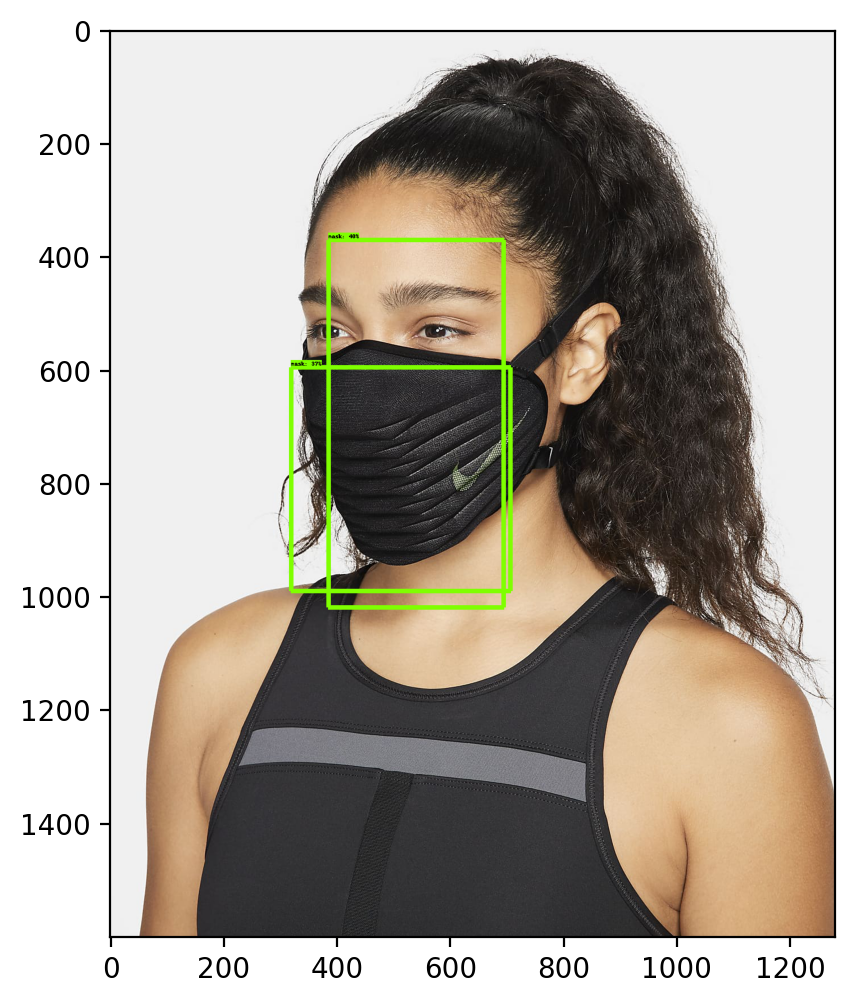

In [ ]:
# you can add images as you want in IMAGE_PATHS, this loop will do detection for every one of them
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
IMAGE_SIZE = (8, 6)
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


for image_path in image:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    #input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    #input_tensor = input_tensor[tf.newaxis, ...].dtypes("float32")
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes']+label_id_offset,
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False,
          line_thickness=8)

    plt.figure(figsize=IMAGE_SIZE, dpi=200)
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

This model is trained with very not-diversed, low-resolution, and little data. The solutions for images other then test images I created will be bad like this. Try it on with more diversed and high-resolution images. Or maybe you can try it for other tasks. Maybe sign language, glasses vs. detections.